# Exercise 4: Extension 2



### Potentials

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import vegas
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Harmonic
def v_sho(x):
    
    return (x**2)/2

#Anharmonic
def v_aho(x):
    
    return (x ** 4)/2


### Action for One Spatial Point

In [120]:
def action(x, i, v, m, a): 
    ir = (i+1)%len(x) 
    il = (i-1)%len(x)
    return a *  v(x[i]) + (m/a) * x[i] * (x[i]-x[ir]-x[il])

### Update Function

In [121]:
def update(x, v, m, a, dx):
    #Updates Every Point Once
    accept = 0
    for i in range(len(x)):
        
        x_old = x[i]
        old_action = action(x=x, i=i, v=v, m=m, a=a)
        
        x[i] += np.random.uniform(-dx, dx)
        new_action = action(x=x, i=i, v=v, m=m, a=a)
        
        diff = old_action - new_action
        
        r = np.minimum(1.0, np.exp(diff))
    
        if r < np.random.rand():
            x[i] = x_old
        
        else:
            accept += 1
    
    return x, accept / len(x)

### Two Point Function

In [122]:
def G(x):
    #Returns Array Gn = [G1, G2,...]
    n = len(x)
    g = np.zeros(n)
    for j in range(n):
        for i in range(n):
            g[j] += (x[(i+j)%(n)]) *(x[i])
            
    return g/n

### Markov Chain Generation

In [123]:
def markov_chain(n_sites, n_configs, v, m, a, dx, n_corr):
    
    acceptance = 0
    config = np.zeros((n_sites))
    gn = []
    
    #Thermalise
    for i in range(10*n_corr):
        config = update(config, v, m, a, dx)[0]


    for i in range(n_configs*n_corr):
        config, acc = update(config, v, m, a, dx)
        acceptance += acc
        
        if i % n_corr == 0:
            gn.append(G(config))
            
    acceptance = acceptance / (n_configs*n_corr)       
    return gn, acceptance

### Error Stuff

In [124]:
def binning(g, bin_size):
    g_bin = []
    g_bin_err =[]
    Ncf = len(g)
    for i in range(0, Ncf, bin_size):
        bin_val = np.mean(g[i:i+bin_size],0)
        bin_val_err = np.std(g[i:i+bin_size],0) / np.sqrt(bin_size)
        g_bin.append(bin_val)
        g_bin_err.append(bin_val_err)
    return np.array(g_bin), np.array(g_bin_err)

def jacknife(g):
    g_jacknife = []
    g_jacknife_err = []
    Ncf = len(g)
    for i in range(Ncf):
        b = np.delete(g,i,0)
        jknife_avg = np.mean(b, 0)
        jknife_err = np.std(b, 0) / np.sqrt(Ncf - 1)
        g_jacknife.append(jknife_avg)
        g_jacknife_err.append(jknife_err)
    return g_jacknife, g_jacknife_err

    
        
        
def analysis_binned(n_sites, n_configs, v, m, a, dx, n_corr, bin_size, harmonic=True):
    

    fig, axs =  plt.subplots(nrows=n_sites, ncols=1, figsize=(12, 48), dpi=100)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    
    gn, acc = markov_chain(n_sites=n_sites, n_configs=n_configs, v=v, m=m, a=a, dx=dx, n_corr=n_corr)
        
    binned_g, binned_g_err = binning(g=gn, bin_size=bin_size)
    jacknife_g, jacknife_g_err = jacknife(g=gn)
    
    
    for i in range(20):
        data = {}
        data["hist" ], data["edges"] = np.histogram(binned_g[:,i], bins = 100, density = True)
        data["centres"] = (data["edges"][:-1] + data["edges"][1:])/2
    
        axs[i].plot(data["centres"], data["hist"], 'o')
        axs[i].set_xlim(-1, 1)

        
    plt.show()
    
    

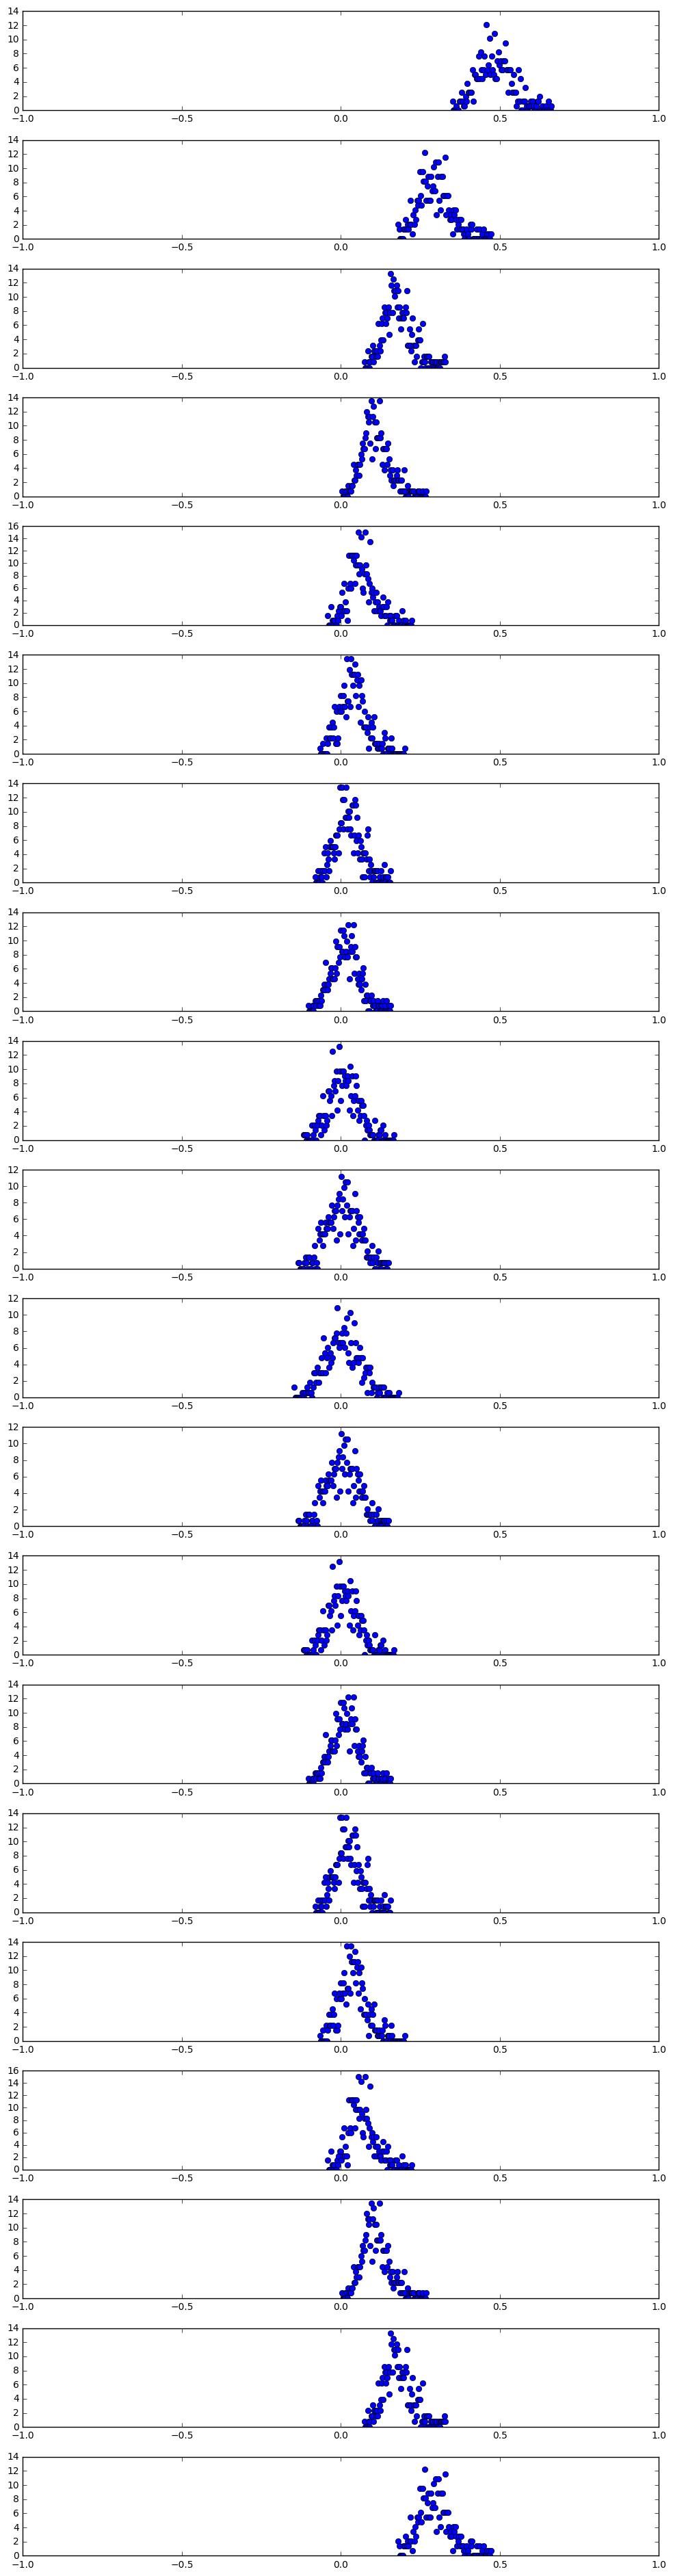

In [125]:
analysis_binned(n_sites=20, n_configs = 10000 , v=v_sho, m=1, a=0.5, dx=1.4, n_corr=20, bin_size = 20)

#### Question

For binning errors do I divide by the square root of the original number of configs or number of configs / bin size.

Not possible to fit or preform functional operations on a single configuration (They flucuate too wildy). Need to average then preform fit / operations. Have to propagate errors!

If I bin, can I then preform these fits/ operations on a single binned configuration and then calculate the error on the final ensemble of fits / functionally changed data.

How about jacknife and bootstrap? How many configurations do i need to average to create a new ensemble that I can analyse individual configurations?

Are my bootstrap, jacknife, binning errors correct?